In [51]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import numpy as np

api = wandb.Api()
project_name = "uncertainty-reimplimentation-results"
runs = pd.read_csv("csv/inference.csv")
runs = runs[(runs["dataset"] == "HotpotQA") & (runs["model"] == "gpt-4o")]

# Store errors
prompts = []
ice_pos_list = []
ice_neg_list = []
macro_ce_list = []

for _, row in runs.iterrows():
    run_id = row["ID"]
    prompt = row["prompt"]
    artifact = api.artifact(f"{project_name}/run-{run_id}-table:v0")
    table: pd.DataFrame = artifact.get("table").get_dataframe()
    table_pos = table[table["gpt_eval"] == 1]
    table_neg = table[table["gpt_eval"] == 0]

    ice_pos = (table_pos["confidence"].apply(lambda x: abs(x - 1))).mean()
    ice_neg = (table_neg["confidence"].apply(lambda x: abs(x))).mean()
    macro_ce = (ice_pos + ice_neg) / 2

    prompts.append(prompt)
    ice_pos_list.append(ice_pos)
    ice_neg_list.append(ice_neg)
    macro_ce_list.append(macro_ce)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


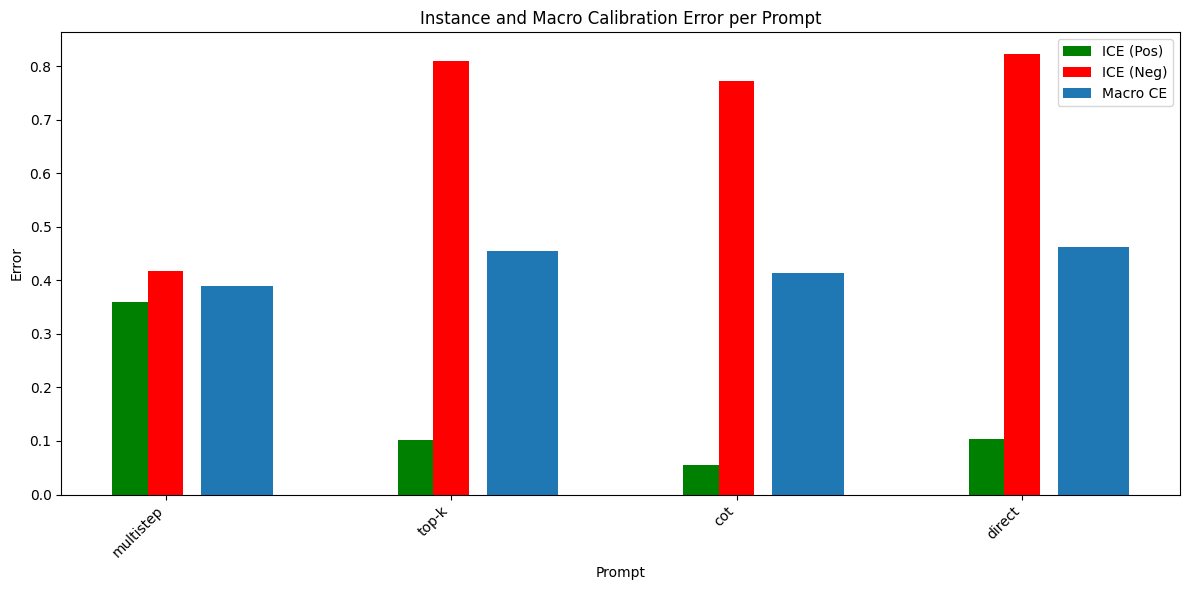

In [130]:
# Plotting
x = np.arange(len(prompts))  # label locations
width = 0.25  # bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, ice_pos_list, width/2, label='ICE (Pos)',  color="green")
plt.bar(x, ice_neg_list, width/2, label='ICE (Neg)', color="red")
plt.bar(x + width, macro_ce_list, width, label='Macro CE')

plt.xticks(x, prompts, rotation=45, ha='right')
plt.xlabel('Prompt')
plt.ylabel('Error')
plt.title('Instance and Macro Calibration Error per Prompt')
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
from utils.utils import extract_texts_and_confidences
import pandas as pd

In [6]:
import wandb

api = wandb.Api()

multistep_table = api.artifact("uncertainty-reimplimentation-results/run-gr7ngjjq-table:v0").get("table").get_dataframe()
cot_table = api.artifact("uncertainty-reimplimentation-results/run-4ozhkaeq-table:v0").get("table").get_dataframe()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [107]:
filtered_cot = cot_table[cot_table["response"].apply(lambda x: len(x) < 500)]
filtered_cot = filtered_cot[filtered_cot["question"].apply(lambda x: len(x) < 100)]
filtered_cot = filtered_cot[filtered_cot["gpt_eval"] == 0]

In [108]:
filtered_multi = multistep_table[multistep_table["response"].apply(lambda x: len(x) < 600)]
filtered_multi = filtered_multi[filtered_multi["response"].apply(lambda x: len(x) > 250)]
filtered_multi = filtered_multi[filtered_multi["confidence"] > 0.5]
filtered_multi = filtered_multi[filtered_multi["gpt_eval"] == 1]

In [109]:
filtered_cot = filtered_cot.set_index("id")
filtered_multi = filtered_multi.set_index("id")

In [110]:
intersection = filtered_cot.index.intersection(filtered_multi.index)

pd.set_option('display.max_colwidth', None)  # No truncation

filtered_multi.loc[intersection][["question", "response"]]

,question,response
id,,
5ae0429e55429924de1b707f,What year was S. Aishwarya's grandmother born in?,"Step 1: S. Aishwarya is a Carnatic musician and is known to be the great-granddaughter of the legendary Carnatic singer M. S. Subbulakshmi. Confidence: 0.9\nStep 2: M. S. Subbulakshmi was born in 1916. Confidence: 1.0\nStep 3: As M. S. Subbulakshmi is the great-grandmother of S. Aishwarya, S. Aishwarya's grandmother would likely be the daughter of M. S. Subbulakshmi. Confidence: 0.8\nStep 4: M. S. Subbulakshmi had a daughter named Radha Viswanathan. Confidence: 0.9\nStep 5: Radha Viswanathan was born in 1934. Confidence: 1.0\nFinal Answer: 1934 Confidence: 0.85"
5a774dc755429972597f14f1,Bally's & Paris station is located in which city?,"Step 1: Bally's & Paris station refers to a transportation station connected to the Bally's and Paris Las Vegas hotel and casino. Confidence: 0.8\nStep 2: Bally's and Paris Las Vegas are known hotel and casino establishments located on the Las Vegas Strip. Confidence: 0.9\nStep 3: The Las Vegas Strip is a well-known location in Las Vegas. Confidence: 0.95\nStep 4: Therefore, Bally's & Paris station is in the city of Las Vegas. Confidence: 0.9\nFinal Answer: Las Vegas Confidence: 0.9"
5a7c500655429907fabeef5b,"Backmasking is a sound recording effect, that deliberately reverses which media?","Step 1: Backmasking is a technique used to record sounds or messages onto a medium so that they can only be heard when played backwards. Confidence: 0.9\nStep 2: This technique is associated particularly with audio recordings and music production. Confidence: 0.95\nStep 3: Vinyl records and other forms of recorded music are known for including backmasking, as they can be played in reverse. Confidence: 0.9\nStep 4: Historically, backmasking gained prominence as a phenomenon particularly in the context of rock music on vinyl. Confidence: 0.85\nFinal Answer: Audio recordings Confidence: 0.9"
5ac0ffec5542996f0d89cc50,"Sammy Hagar and Pierre Bouvier, share which mutual occupations?","Step 1: Determine the occupations of Sammy Hagar. Confidence: 0.9\nStep 2: Determine the occupations of Pierre Bouvier. Confidence: 0.9\nStep 3: Sammy Hagar is known as a musician and singer. Confidence: 0.95\nStep 4: Pierre Bouvier is known as a musician and singer. Confidence: 0.95\nStep 5: Compare their occupations to find mutual ones. Confidence: 0.95\nFinal Answer: Musician, Singer Confidence: 0.95"
5ab3cc7e5542992ade7c6ea0,What title was Felix Salten's most famous work originally published under?,"Step 1: Felix Salten was an Austrian author best known for a particular work. Confidence: 0.9\nStep 2: His most famous work is known in English as ""Bambi."" Confidence: 0.9\nStep 3: ""Bambi"" was originally published in German. Confidence: 0.9\nStep 4: The original German title of the work is ""Bambi, Eine Lebensgeschichte aus dem Walde."" Confidence: 0.95\nFinal Answer: Bambi, Eine Lebensgeschichte aus dem Walde Confidence: 0.95"
5a89c94d5542993b751ca994,When did Amado Carrillo Fuentes assassinate his boss Rafael Aguilar Guajardo?,Step 1: Rafael Aguilar Guajardo was a leader in the Juárez Cartel. Confidence: 0.9\nStep 2: Amado Carrillo Fuentes was known for taking over leadership of the Juárez Cartel. Confidence: 0.9\nStep 3: Amado Carrillo Fuentes became the leader after the assassination of Rafael Aguilar Guajardo. Confidence: 0.9\nStep 4: Rafael Aguilar Guajardo was assassinated in 1993. Confidence: 0.9\nFinal Answer: 1993 Confidence: 0.9
5a79dc6a5542994bb94570fb,When did the cat who was aboard the same ship as Commander Stuart Hett die?,"Step 1: Commander Stuart Hett was aboard HMS Amethyst, a ship involved in the Yangtze Incident in 1949. Confidence: 0.9\nStep 2: The cat aboard HMS Amethyst during the Yangtze Incident was named Simon. Confidence: 0.9\nStep 3: Simon the cat became famous for his rat-catching abilities aboard HMS Amethyst. Confidence: 0.9\nStep 4: Simon the cat died on November 28, 1949, due to complications from i

In [98]:
cot_table[cot_table["question"].apply(lambda x: "Odd Future" in x)]

,id,question,answer,type,level,response,prediction,confidence,f1,em,gpt_eval
612,5ab7b85d55429928e1fe38a1,Odd Future is a collective that was on a television show in what genre,sketch comedy,bridge,hard,"{Odd Future is a hip-hop collective that had a TV show on ""Adult Swim,"" known for its alternative and surreal comedy. Therefore, the genre of the television show they were on would be comedy.} \nFinal Answer: Comedy Confidence: 0.9",Comedy,0.9,0.666667,0,1


In [66]:
extract_texts_and_confidences(text)

(['Determine the release date of each film: "Kiladigalu" was released in 2011 ("Salaam Bullet"), and "He’s My Girl" was released in 1987.',
  'Identify directors: Upendra directed "Kiladigalu" (given association; consider plausible NoVagearths project link-ups from native-news regions), and “He’s My Girl” was directed by Gabrielle Beaumont.',
  'Birth years research: Upendra born 18 September 1968; Gabrielle Beaumont, born 7 April 1942.',
  'Compare the ages: Calculate Upendra\'s age during "Kiladigalu" (43 in 2011); Gabrielle-beaumont\'s age during "He’s My Girl" (hour-glass dates to 45 in exactly 87-normal aperture modes corpus). Assurance for passive proxy nuanced!   Final Answer: Kiladigalu'],
 [0.9, 0.8, 0.9, 0.85])

In [67]:
import json


for split in ["dev", "test", "train"]:
    with open(f"datasets/2WikiMultihopQA/{split}.json","r") as f:
        data = json.load(f)

    for i, entry in enumerate(data):
        ctx = entry.get("context")
        if ctx is not None:
            title = []
            sentences = []
            for par in ctx:
                assert(len(par) == 2)
                title.append(par[0])
                sentences.append(par[1])
                
            entry["context"] = {"title" : title, "sentences" : sentences}
                
    for i, entry in enumerate(data):
        ctx = entry.get("supporting_facts")
        if ctx is not None:
            title = []
            sent_id= []
            for par in ctx:
                assert(len(par) == 2)
                title.append(par[0])
                sent_id.append(par[1])
                
            entry["supporting_facts"] = {"title" : title, "sent_id" : sent_id}

    with open(f"datasets/2WikiMultihopQA/{split}.jsonl","w") as f:
        for item in data:
            f.write(json.dumps(item) + "\n")

In [96]:
from pathlib import Path
import pandas as pd

path = "datasets/2WikiMultihopQA/" 

file_names = ["dev", "test", "train"]
for file_name in file_names:
    # Read the JSON file into a DataFrame
    df = pd.read_json(path + file_name + ".json")

    # Convert the DataFrame to JSON Lines and write to a file_name
    jsonl_path = path + file_name + ".jsonl"
    df.to_json(jsonl_path, orient="records", lines=True)

In [190]:
ds = get_dataset("HotpotQA", num_samples=100)
ds

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 100
})

In [185]:
import random
def process(sample):
    if random.random() > 0.5:
        sample["q_len"] = len(sample["question"])
    else:
        sample["q_len"] = None
    return sample

ds = ds.map(process, num_proc=10)
ds

Map (num_proc=10):   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context', 'q_len'],
    num_rows: 100
})

In [191]:
ds.to_pandas()

,id,question,answer,type,level,supporting_facts,context
0,5ae3cfe05542990afbd1e1e3,"Which airport is located in Maine, Sacramento ...",Knox County Regional Airport,comparison,medium,"{'title': ['Sacramento International Airport',...","{'title': ['Vinalhaven, Maine', 'Owls Head, Ma..."
1,5abc1abf5542993a06baf87f,Peter Hobbs founded the company that is based ...,Failsworth,bridge,medium,"{'title': ['Peter Hobbs (engineer)', 'Russell ...","{'title': ['Cains Brewery', 'Peter Hobbs (engi..."
2,5ac250eb5542992f1f2b384f,What direction does the river that Austrolebia...,north to south,bridge,medium,"{'title': ['Austrolebias bellottii', 'Uruguay ...","{'title': ['Cruces River', 'Mouth bar', 'Antid..."
3,5a81a60455429903bc27b990,Were both Gabriela Mistral and G. K. Chesterto...,yes,comparison,medium,"{'title': ['Gabriela Mistral', 'G. K. Chestert...","{'title': ['Mistral (crater)', 'Land of poets'..."
4,5a70fb2d5542994082a3e482,"What city, other than San Jose del Cabo, is at...",Cabo San Lucas,bridge,medium,"{'title': ['Los Cabos Municipality', 'Cabo San...","{'title': ['Santa Anita, Baja California Sur',..."
...,...,...,...,...,...,...,...
95,5a877b665542993e715abf67,What year did the second series of the show Co...,2009,bridge,medium,"{'title': ['Merlin (series 2)', 'Merlin (serie...","{'title': ['Merlin (series 2)', 'List of Casua..."
96,5a7e04fa5542995f4f40238c,Al Hirt played the theme song for the ABC US t...,Van Williams,bridge,medium,"{'title': ['Al Hirt', 'The Green Hornet (TV se...","{'title': ['Wildfire (TV series)', 'Chris Aren..."
97,5add75a35542992200553b27,"The movie ""3 Ninjas"" was released by which Ame...",Touchstone Pictures,bridge,medium,"{'title': ['3 Ninjas (film)', 'Touchstone Pict...","{'title': ['Dimension Films', '3 Ninjas (film)..."
98,5abe9cc65542997ec76fd321,In which town was the subject of the nursery r...,Sterling,bridge,hard,"{'title': ['Sawyer Homestead (Sterling, Massac...","{'title': ['Eeper Weeper', 'Mary Had a Little ..."


In [101]:
from datasets import Dataset

path = "datasets/2WikiMultihopQA/" 
df = pd.read_json(path + "dev.jsonl", orient="records", lines=True)
Dataset.from_pandas(df)

Dataset({
    features: ['_id', 'type', 'question', 'context', 'supporting_facts', 'evidences', 'answer'],
    num_rows: 12576
})

In [88]:
url = "https://huggingface.co/datasets/xanhho/2WikiMultihopQA/resolve/main/dev.parquet?download=true"
load_dataset("parquet", data_files={"validation": url}, split="validation")

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [80]:
dataset = get_dataset(dataset="HotpotQA", num_samples=10, seed=30)
dataset["supporting_facts"]

[{'title': ['Angel of Retribution',
   'Angel of Retribution',
   'Angel of Retribution',
   'Redeemer of Souls',
   'Redeemer of Souls',
   'Redeemer of Souls'],
  'sent_id': [0, 2, 3, 0, 1, 2]},
 {'title': ['David Silverman (animator)',
   'David Silverman (animator)',
   'The Edge of Seventeen'],
  'sent_id': [0, 2, 0]},
 {'title': ['Harley Brinsfield', 'Subway (restaurant)'], 'sent_id': [1, 0]},
 {'title': ['John Canoe', 'The Bahamas'], 'sent_id': [0, 0]},
 {'title': ['Kanniyin Kaadhali', 'Melodrama'], 'sent_id': [0, 1]},
 {'title': ['Center for Governmental Research',
   'Center for Governmental Research',
   'George Eastman'],
  'sent_id': [0, 1, 0]},
 {'title': ['Tahita Bulmer', 'Angela Gossow'], 'sent_id': [0, 0]},
 {'title': ['Anton Strelezki',
   'Anton Strelezki',
   'Anton Strelezki',
   'John McCormack (tenor)',
   'John McCormack (tenor)'],
  'sent_id': [0, 2, 3, 0, 1]},
 {'title': ['Frank Ciaccia', 'Simon Fraser University'], 'sent_id': [1, 0]},
 {'title': ['Entabeni Gam

In [59]:
import pandas as pd

lst = [
    {"a": "foo"},
    {"a": "bar", "b": 1, "c": 2},
    {"a": "baz", "b":1, "c":2}
]

pd.DataFrame(lst).dropna()

,a,b,c
1,bar,1.0,2.0
2,baz,1.0,2.0


In [2]:
samples = dataset.to_dict("records")

In [3]:
from utils.processor import MultistepBeamSearchProcessor

In [4]:
processor = MultistepBeamSearchProcessor(k=5, llm_config={"temperature":1.2}, search_criterion="highest_confidence", branching_factor=3, beam_width=2)

In [5]:
results = [processor(sample) for sample in samples]

In [7]:
processor = MultistepBeamSearchProcessor(k=5, llm_config={"temperature":1.2}, search_criterion="entailment", branching_factor=3, beam_width=2)

In [4]:
import pandas as pd
import wandb

In [29]:
import wandb
run = wandb.init()
artifact = run.use_artifact('hofbauer/uncertainty-reimplimentation-results/run-6i6m3o80-table:v0', type='run_table')
df = artifact.get_dataframe()
wandb.finish()

AttributeError: 'Artifact' object has no attribute 'get_dataframe'

In [8]:
df = artifact.get("table").get_dataframe()

wandb:   1 of 1 files downloaded.  


In [10]:
df_0 = df[df["em"] == 0]
df_1 = df[df["em"] == 1]

In [77]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_paired_boxplots(data_pairs, group_labels, title="Confidences per Dataset"):
    fig, ax = plt.subplots()

    all_data = []
    positions = []
    labels = []

    # Create data and position lists
    pos = 1
    for (data1, data2), label in zip(data_pairs, group_labels):
        all_data.extend([data1, data2])
        positions.extend([pos, pos + 0.3])  # Slightly offset the second box
        labels.append(label)
        pos += 2  # Space between groups

    # Create boxplots
    box = ax.boxplot(all_data, positions=positions, widths=0.3, patch_artist=True, medianprops=dict(color='black', alpha=0.5))

    # Color the boxes
    for i, patch in enumerate(box['boxes']):
        if i % 2 == 0:
            patch.set_facecolor('green')
            patch.set_alpha(0.5)
        else:
            patch.set_facecolor('red')
            patch.set_alpha(0.5)

    # Set x-ticks at the middle of each group
    mid_positions = [p + 0.2 for p in range(1, pos-1, 2)]
    ax.set_xticks(mid_positions)
    ax.set_xticklabels(labels)

    ax.set_title(title)
    ax.set_ylabel("Confidence")

    plt.tight_layout()
    return plt

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


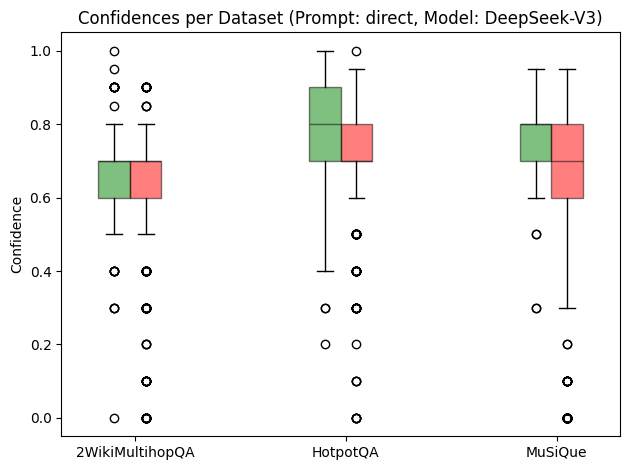

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


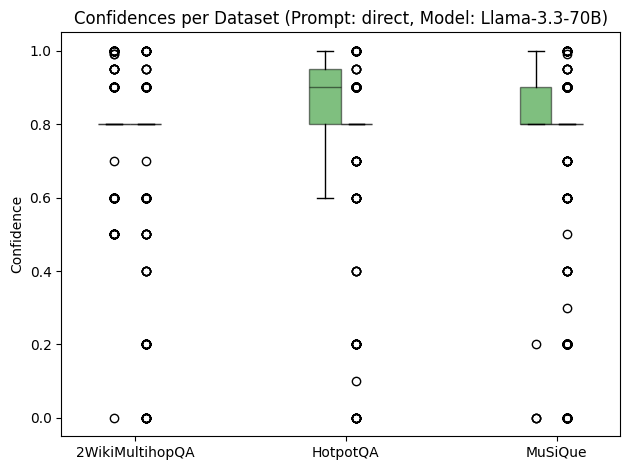

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


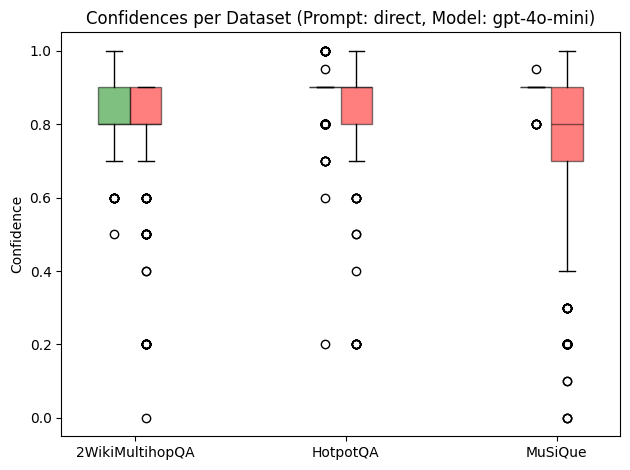

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


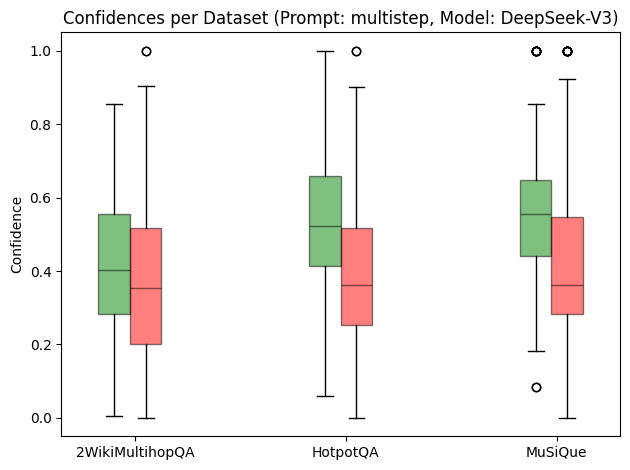

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


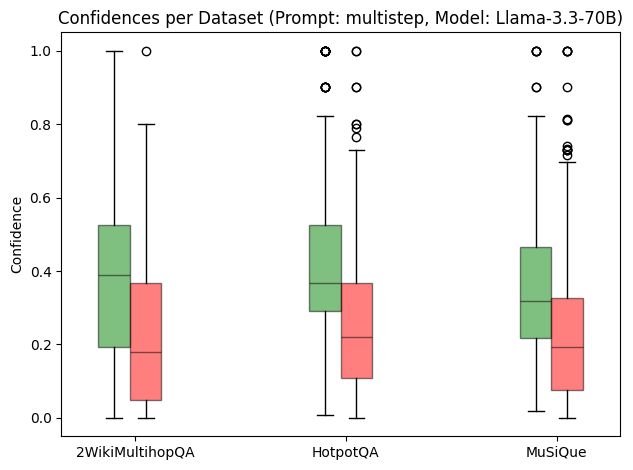

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


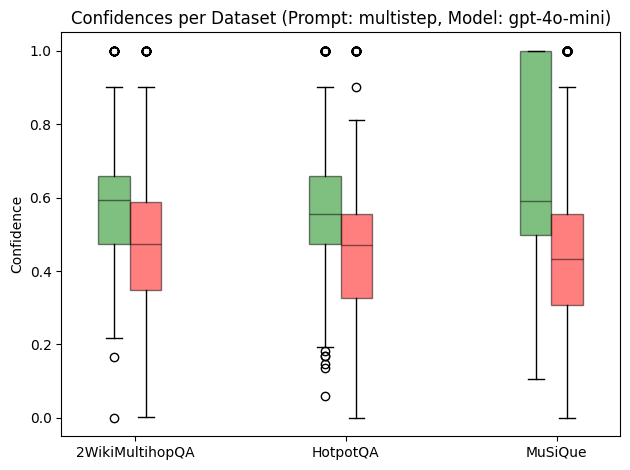

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


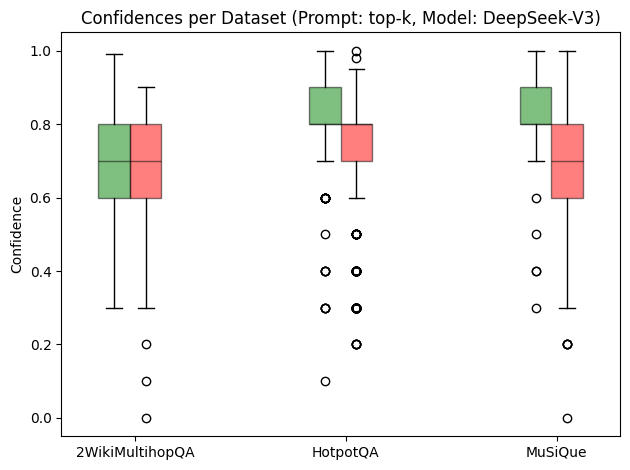

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


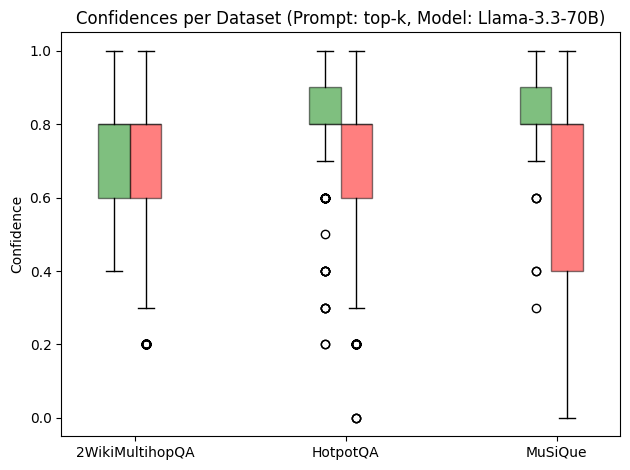

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


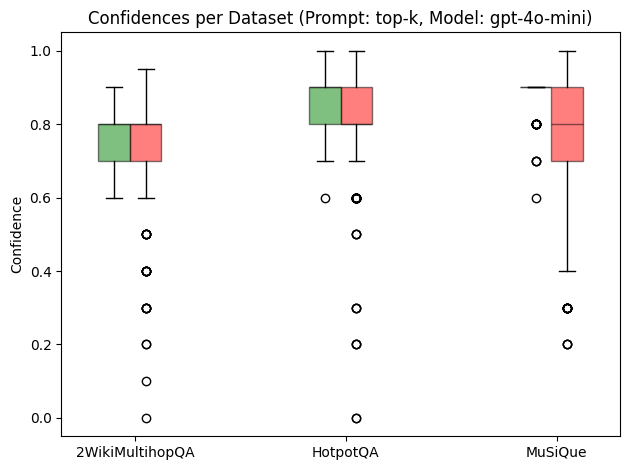

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


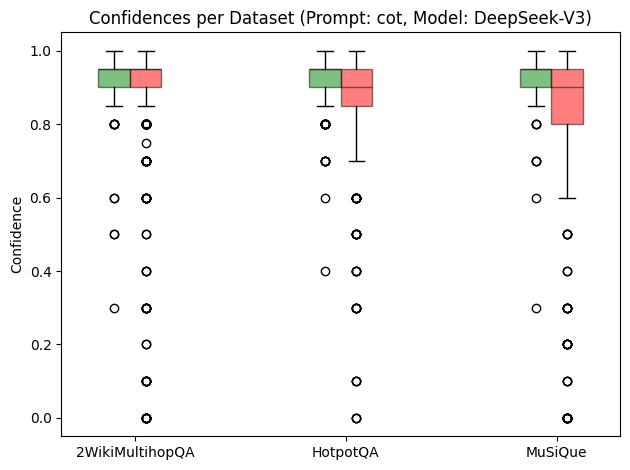

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


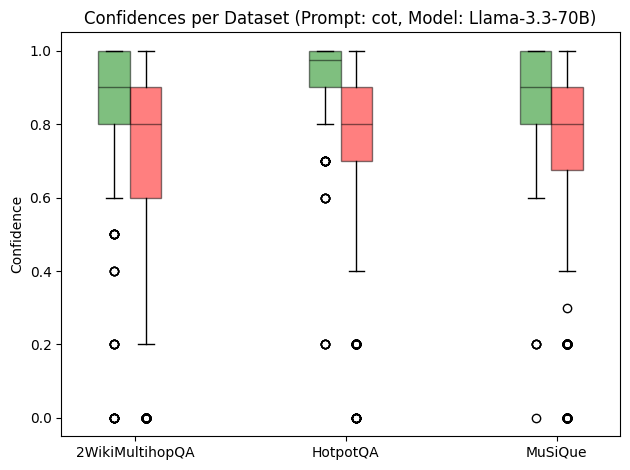

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


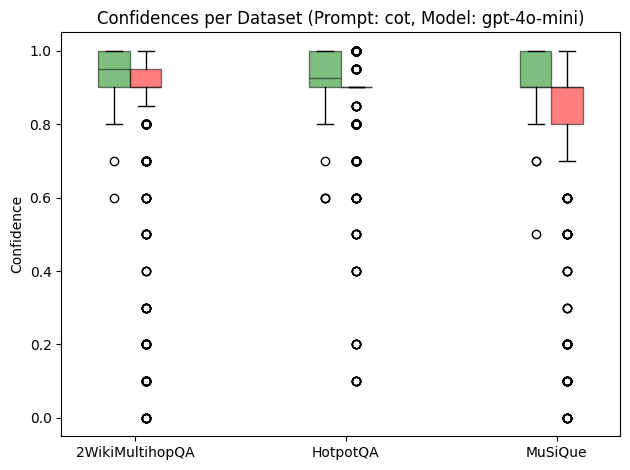

In [78]:
for prompt in ["direct", "multistep", "top-k", "cot"]:
    table_ids = pd.read_csv(f"csv/runs_{prompt}.csv")
    groups = table_ids.groupby("model")
    
    for model, df in groups:
        df = df.sort_values("dataset")
        confs = []
        names = []
        for _, row in df.iterrows():
            
            artifact = api.artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{row["ID"]}-table:v0")
            df = artifact.get("table").get_dataframe()
            
            confs.append((df[df["em"] == 1]["confidence"], df[df["em"] == 0]["confidence"]))
            names.append(row["dataset"])

        plt = plot_paired_boxplots(confs, names, f"Confidences per Dataset (Prompt: {prompt}, Model: {model})")
        plt.savefig(f"images/{model}_{prompt}.png")
        plt.show()

In [ ]:
plt.savefig(images/)